# Image Classification with Transfer Learning

# Introduction

This notebook explores image classification using transfer learning techniques.
We will demonstrate two popular approaches: feature extraction and fine-tuning.
Our focus will be on leveraging pretrained models like EfficientNet and MobileNetV2
to achieve accurate image classification on a custom dataset.


# Objectives

The primary goals of this notebook are as follows:

1.  Utilize pretrained ImageNet models (EfficientNet, MobileNetV2) as a foundation.
2.  Implement and evaluate the feature extraction approach.
3.  Implement and evaluate the fine-tuning approach.
4.  Compare the performance of both approaches on our target dataset.

## Import Required Libraries
We need TensorFlow for building models, TensorFlow Hub for accessing pretrained models, sklearn for evaluation metrics, and visualization libraries. These tools enable us to leverage powerful pretrained models for custom classification tasks.

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

## Dataset Preparation
Load and preprocess the CIFAR-10 dataset for transfer learning. We normalize pixel values to [0,1] range and split the data into training, validation, and test sets. CIFAR-10 contains 60,000 32x32 color images in 10 classes, making it ideal for demonstrating transfer learning techniques.

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training samples: 40000
Validation samples: 10000
Test samples: 10000


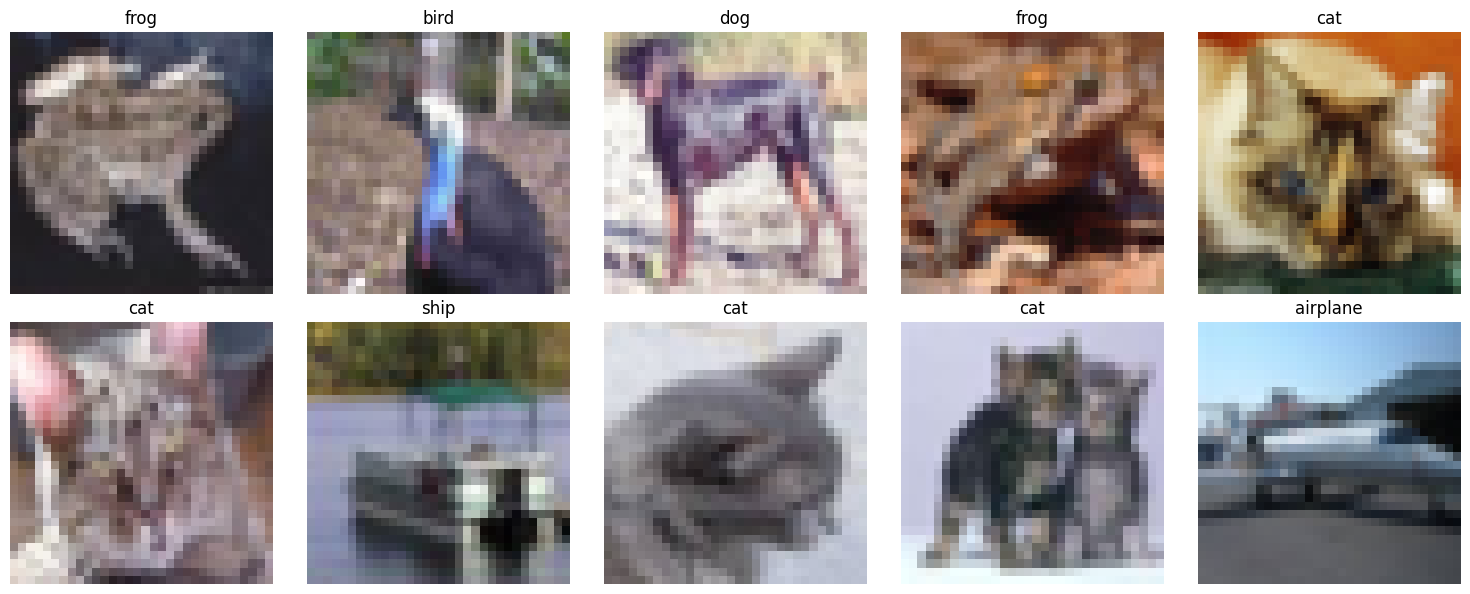

In [ ]:
# Load CIFAR-10 dataset for transfer learning demonstration
print("Loading CIFAR-10 dataset...")
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess data
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train_full = y_train_full.reshape(-1)
y_test = y_test.reshape(-1)

# Split training data into train and validation
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full, test_size=0.2, random_state=42
)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")

# Display sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()
for i in range(10):
    axes[i].imshow(x_train[i])
    axes[i].axis('off')
    axes[i].set_title(class_names[y_train[i]])
plt.tight_layout()
plt.show()

## Data Augmentation and Datasets
The data pipeline adds a temporary batch dimension for augmentation, applies random transformations, then removes the extra dimension. This approach correctly handles the shape requirements of Keras augmentation layers. The visualization shows the original and augmented images, demonstrating how data augmentation creates variations.

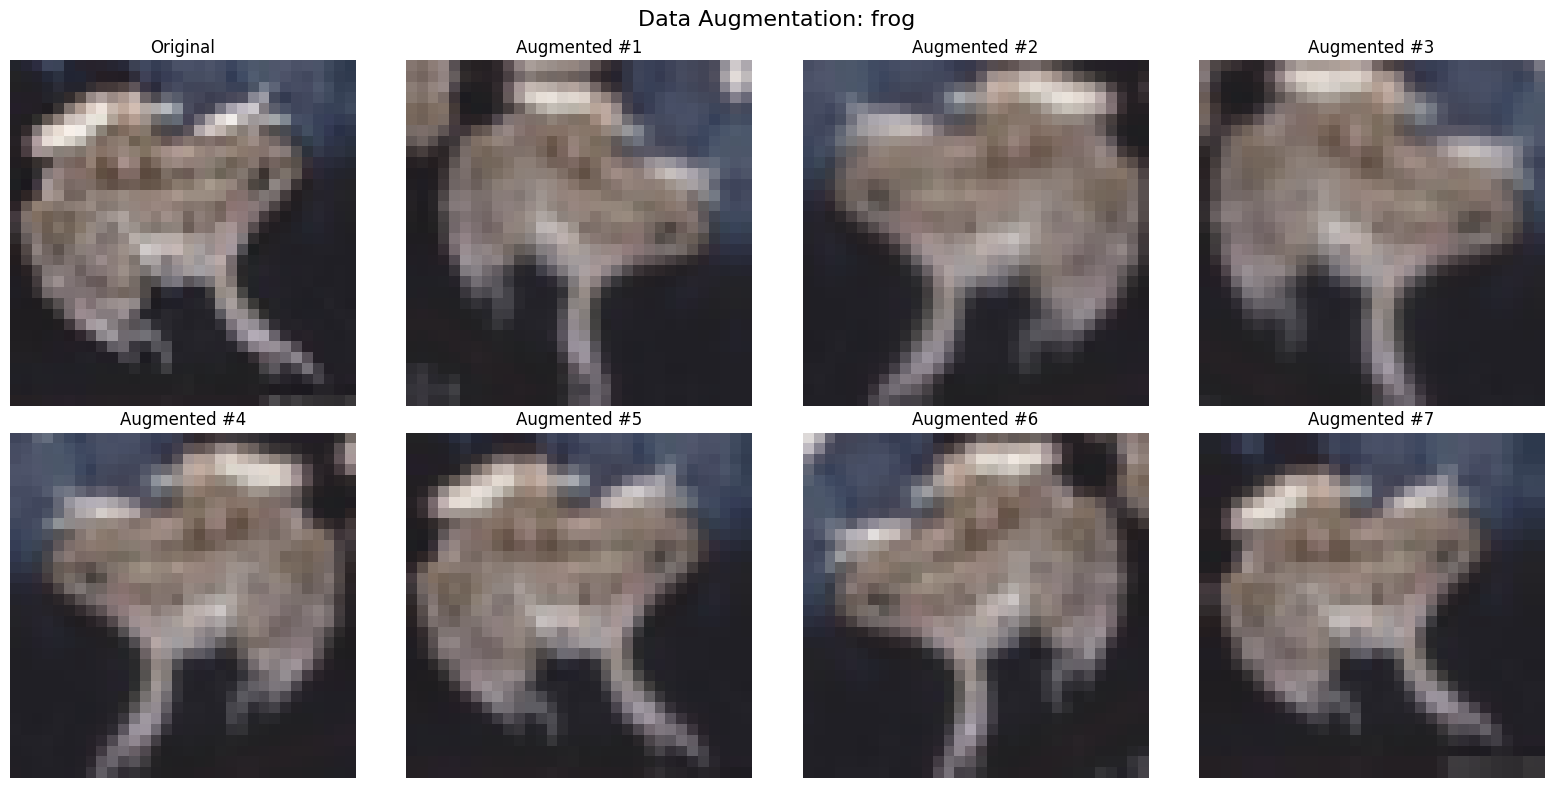

In [ ]:
# Implement data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Create datasets with augmentation
def prepare_dataset(x, y, batch_size=32, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    if augment:
        # Add batch dimension for augmentation, then remove it
        ds = ds.map(lambda x, y: (tf.expand_dims(x, 0), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.map(lambda x, y: (tf.squeeze(x, axis=0), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# Create augmented datasets
train_ds = prepare_dataset(x_train, y_train, augment=True)
val_ds = prepare_dataset(x_val, y_val, shuffle=False)
test_ds = prepare_dataset(x_test, y_test, shuffle=False)

# Visualize augmentation effects
sample_image = x_train[0]
sample_label = y_train[0]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

# First show the original image
axes[0].imshow(sample_image)
axes[0].axis('off')
axes[0].set_title('Original')

# Then show augmented versions
for i in range(1, 8):
    # Apply augmentation and convert to numpy
    augmented = data_augmentation(tf.expand_dims(sample_image, 0), training=True)
    augmented_image = tf.squeeze(augmented, axis=0).numpy()
    axes[i].imshow(augmented_image)
    axes[i].axis('off')
    axes[i].set_title(f'Augmented #{i}')

plt.suptitle(f'Data Augmentation: {class_names[sample_label]}', fontsize=16)
plt.tight_layout()
plt.show()

## Feature Extraction with EfficientNet
Load EfficientNetB0 pretrained on ImageNet and use it as a feature extractor. We freeze the base model weights and only train the classification head. This approach:
1. Leverages powerful pretrained features
2. Requires less computational resources
3. Trains faster than fine-tuning
4. Works well when ImageNet features transfer well to your task

In [ ]:
# Load EfficientNetB0 for feature extraction
print("Loading EfficientNetB0...")
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Freeze the base model
base_model.trainable = False

# Build feature extraction model
feature_extraction_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    base_model,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

feature_extraction_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
print("\nFeature Extraction Model Summary:")
feature_extraction_model.summary()

Loading EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Feature Extraction Model Summary:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,222,445 (16.11 MB)

 Trainable params: 172,874 (675.29 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Training Models
Train the feature extraction model first, then prepare for fine-tuning. Fine-tuning is done in two phases:
1. Phase 1: Train only the classification head with base model frozen
2. Phase 2: Unfreeze some layers and train end-to-end (next cell)

This progressive approach helps prevent catastrophic forgetting of pretrained features.

In [ ]:
# Train feature extraction model
print("Training feature extraction model...")
feature_extraction_history = feature_extraction_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

# Evaluate on test set
fe_test_loss, fe_test_accuracy = feature_extraction_model.evaluate(test_ds, verbose=0)
print(f"\nFeature Extraction Test Accuracy: {fe_test_accuracy:.4f}")

# Load EfficientNetB0 for fine-tuning
print("\nPreparing model for fine-tuning...")
base_model_ft = tf.keras.applications.EfficientNetB0(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Initially freeze all layers
base_model_ft.trainable = False

# Build fine-tuning model
fine_tuning_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(32, 32, 3)),
    base_model_ft,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Initial training with frozen base
fine_tuning_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nTraining fine-tuning model (phase 1 - frozen base)...")
fine_tuning_history_initial = fine_tuning_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

Training feature extraction model...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.0958 - loss: 2.3029 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 31ms/step - accuracy: 0.0977 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 39s 32ms/step - accuracy: 0.0968 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 40s 31ms/step - accuracy: 0.0973 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s 31ms/step - accuracy: 0.0953 - loss: 2.3028 - val_accuracy: 0.0933 - val_loss: 2.3030

Feature Extraction Test Accuracy: 0.1000

Preparing model for fine-tuning...

Training fine-tuning model (phase 1 - frozen base)...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 67s 38ms/step - accuracy: 0.1003 - loss: 2.3088 - val_accuracy: 0.0933 - val_loss: 2.3030
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 38s

## Final Results and Comparison
Complete the training process by fine-tuning the top layers of EfficientNet. This visualization shows:
1. Training progress comparison between feature extraction and fine-tuning
2. Final test accuracy comparison
3. Overall improvement achieved through fine-tuning

Key takeaways:
- Feature extraction is faster but may have limited performance
- Fine-tuning can achieve better accuracy but requires careful learning rate tuning
- The two-phase approach prevents catastrophic forgetting while improving accuracy

In [ ]:
# Unfreeze top layers for fine-tuning
print("\nUnfreezing top layers for fine-tuning...")
base_model_ft.trainable = True

# Fine-tune from layer 100 onwards
for layer in base_model_ft.layers[:-50]:
    layer.trainable = False

# Recompile with lower learning rate
fine_tuning_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Training fine-tuning model (phase 2 - partial unfreezing)...")
fine_tuning_history_final = fine_tuning_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    verbose=1
)

# Final evaluation
ft_test_loss, ft_test_accuracy = fine_tuning_model.evaluate(test_ds, verbose=0)
print(f"\nFine-tuning Test Accuracy: {ft_test_accuracy:.4f}")

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Accuracy comparison
ax1.plot(feature_extraction_history.history['accuracy'], label='FE Training', color='blue')
ax1.plot(feature_extraction_history.history['val_accuracy'], label='FE Validation', linestyle='--', color='blue')
combined_ft_acc = fine_tuning_history_initial.history['accuracy'] + fine_tuning_history_final.history['accuracy']
combined_ft_val_acc = fine_tuning_history_initial.history['val_accuracy'] + fine_tuning_history_final.history['val_accuracy']
ax1.plot(range(len(combined_ft_acc)), combined_ft_acc, label='FT Training', color='red')
ax1.plot(range(len(combined_ft_val_acc)), combined_ft_val_acc, label='FT Validation', linestyle='--', color='red')
ax1.axvline(x=10, color='green', linestyle='--', alpha=0.7)
ax1.text(10.5, 0.6, 'Fine-tuning started', rotation=90)
ax1.set_title('Model Accuracy Comparison', fontsize=16)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Final comparison bar chart
results = {
    'Feature Extraction': fe_test_accuracy,
    'Fine-tuning': ft_test_accuracy
}
methods = list(results.keys())
accuracies = list(results.values())
ax2.bar(methods, accuracies, color=['blue', 'red'], alpha=0.7)
ax2.set_title('Final Test Accuracy Comparison', fontsize=16)
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for i, acc in enumerate(accuracies):
    ax2.text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)
print(f"Feature Extraction Test Accuracy: {fe_test_accuracy:.2%}")
print(f"Fine-tuning Test Accuracy: {ft_test_accuracy:.2%}")
improvement = ((ft_test_accuracy - fe_test_accuracy) / fe_test_accuracy) * 100
print(f"Improvement: {improvement:.2f}%")
print("="*50)


Unfreezing top layers for fine-tuning...
Training fine-tuning model (phase 2 - partial unfreezing)...
Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.1053 - loss: 2.5099 - val_accuracy: 0.1208 - val_loss: 2.3076
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.1056 - loss: 2.3419 - val_accuracy: 0.0897 - val_loss: 2.3050
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.1084 - loss: 2.3192 - val_accuracy: 0.0868 - val_loss: 2.3026
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.1124 - loss: 2.3077 - val_accuracy: 0.0910 - val_loss: 2.3027
Epoch 5/5
 739/1250 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.1234 - loss: 2.2970